In [11]:
import pandas as pd

import numpy as np
from tqdm import tqdm

from numba import jit
import time

import os

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# read in the dataframe you want to clean, can be a csv, hdf

traindf = pd.read_csv("./data/training_set_VU_DM.csv")
    
# traindf = traindf[:100000]

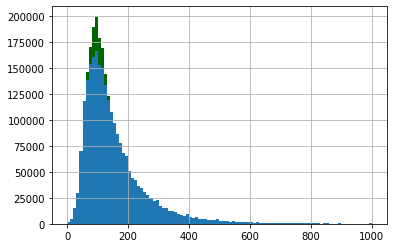

In [13]:
traindf["price_usd"][(traindf["srch_saturday_night_bool"] == 1) & (traindf["price_usd"] < 1000)].hist(bins=100, color='DarkGreen')
traindf["price_usd"][(traindf["srch_saturday_night_bool"] == 0) & (traindf["price_usd"] < 1000)].hist(bins=100)

In [14]:
@jit(nopython=True, parallel=True)
def calculate_mean_per_propid(unique_propids, 
                                    col_propids, 
                                    col_price, 
                                    col_mean, 
                                    col_std, 
                                    col_no_hotels, 
                                    col_correct_price, 
                                    col_nights,
                                    col_new_mean,
                                    col_new_std,
                                    cut_off):
    
    total = len(unique_propids)

    worse, better = 0, 0
    
    print("Cutoff: ", cut_off, "\nChanged everything to numpy arrays, starting now with processing data")
        
    for i, propid in enumerate(unique_propids):
        
        if i % 1000 == 0:
            print(cut_off, ": ", i, "/", total)
        
        indices = np.where(col_propids == propid)[0]

        prices = col_price[indices]
        mean_price = np.mean(prices)
        std_price = np.std(prices)
        
        col_mean[indices] = mean_price
        col_std[indices] = std_price
        col_no_hotels[indices] = indices.size
        
        col_new_mean[indices] = mean_price
        col_new_std[indices] = std_price
                       
        if std_price > cut_off:
            col_correct_price[indices] = col_price[indices] / col_nights[indices]
            prices = col_correct_price[indices]
            
            std_price_after = np.std(prices)
            
            # rollback
            if std_price_after > std_price:
                col_correct_price[indices] = col_price[indices]
            else:
                mean_price_after = np.mean(prices)
                
                col_new_mean[indices] = mean_price_after
                col_new_std[indices] = std_price_after


    print("Std before: ", np.mean(col_std), "\nStd after: ", np.mean(col_new_std))


In [15]:
def compute_numba(df, cut_off):
    time_start = time.time()
        
    # add columns
    columnames = list(df.columns)
    columnames.extend(["avg_price_propid", "std_avg_price_propid", "amount_hotels", 
                       "avg_price_propid_after", "std_avg_price_propid_after"])

    df = df.reindex(columns=columnames)

    # copy prices (for now, at the end we will just update the price i suppose)
    df["price_correction"] = df["price_usd"]

    # get unique propids and put them into numpy array
    propids = np.array(df["prop_id"].unique())
    
    print("Appended columns.")
   
    calculate_mean_per_propid(propids,
                                    df['prop_id'].to_numpy(),
                                    df['price_usd'].to_numpy(),
                                    df['avg_price_propid'].to_numpy(),
                                    df['std_avg_price_propid'].to_numpy(),
                                    df['amount_hotels'].to_numpy(),
                                    df['price_correction'].to_numpy(),
                                    df['srch_length_of_stay'].to_numpy(),
                                    df['avg_price_propid_after'].to_numpy(),
                                    df['std_avg_price_propid_after'].to_numpy(),
                                     cut_off)   
    
    print("This took: ", time.time() - time_start)
        
    display(df.head())
    return df

In [16]:
# display(traindf.head())

cutoff = 0
df = compute_numba(traindf, cutoff)

Appended columns.
Cutoff:  0 
Changed everything to numpy arrays, starting now with processing data
0 :  0 / 129113
0 :  1000 / 129113
0 :  2000 / 129113
0 :  3000 / 129113
0 :  4000 / 129113
0 :  5000 / 129113
0 :  6000 / 129113
0 :  7000 / 129113
0 :  8000 / 129113
0 :  9000 / 129113
0 :  10000 / 129113
0 :  11000 / 129113
0 :  12000 / 129113
0 :  13000 / 129113
0 :  14000 / 129113
0 :  15000 / 129113
0 :  16000 / 129113
0 :  17000 / 129113
0 :  18000 / 129113
0 :  19000 / 129113
0 :  20000 / 129113
0 :  21000 / 129113
0 :  22000 / 129113
0 :  23000 / 129113
0 :  24000 / 129113
0 :  25000 / 129113
0 :  26000 / 129113
0 :  27000 / 129113
0 :  28000 / 129113
0 :  29000 / 129113
0 :  30000 / 129113
0 :  31000 / 129113
0 :  32000 / 129113
0 :  33000 / 129113
0 :  34000 / 129113
0 :  35000 / 129113
0 :  36000 / 129113
0 :  37000 / 129113
0 :  38000 / 129113
0 :  39000 / 129113
0 :  40000 / 129113
0 :  41000 / 129113
0 :  42000 / 129113
0 :  43000 / 129113
0 :  44000 / 129113
0 :  45000 / 

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,avg_price_propid,std_avg_price_propid,amount_hotels,avg_price_propid_after,std_avg_price_propid_after,price_correction
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,0,NaN,0,118.758742,17.764203,612.0,118.758742,17.764203,104.77
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,0,NaN,0,152.054082,390.593156,583.0,115.123190,199.201662,170.74
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,0,NaN,0,168.540871,345.165849,551.0,130.074599,179.270492,179.80
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,5.0,0,NaN,0,82.598870,305.433044,460.0,64.152478,154.605742,602.77
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,0,NaN,0,137.648135,432.975724,665.0,103.923122,218.806596,143.58


In [ ]:
display(df[['prop_id', 'amount_hotels', 'avg_price_propid', 'price_usd', 'std_avg_price_propid', 'srch_length_of_stay', 'price_correction', 'avg_price_propid_after', 'std_avg_price_propid_after']][df['prop_id'] == 37304])

display(df[['prop_id', 'amount_hotels', 'avg_price_propid', 'price_usd', 'std_avg_price_propid', 'srch_length_of_stay', 'price_correction', 'avg_price_propid_after', 'std_avg_price_propid_after']].describe())

print(len(df['amount_hotels']), len(df['amount_hotels'].notna()))

In [ ]:

print("Std before: ", df['std_avg_price_propid'].mean())
print("Std after: ", df['std_avg_price_propid_after'].mean())
df['std_avg_price_propid'][df['std_avg_price_propid'] < 2000].hist(bins=100)

plt.figure()
df['std_avg_price_propid_after'][df['std_avg_price_propid'] < 2000].hist(bins=100)

In [ ]:
display(df[['prop_id','std_avg_price_propid', 'std_avg_price_propid_after']][df['std_avg_price_propid_after'] > 10000])
display(df[df['prop_id'] == 13878])

display(df[['prop_id', 'amount_hotels', 'avg_price_propid', 'price_usd', 'std_avg_price_propid', 'srch_length_of_stay', 'price_correction', 'avg_price_propid_after', 'std_avg_price_propid_after']][df['prop_id'] == 13878])

In [ ]:
df.to_hdf("corrected_price_testset_rollback.hdf", key='df')

In [ ]:
@jit(nopython=True, parallel=True)
def calculate_mean_per_srch_id(unique_srchids,
                                    col_srchids,
                                    col_price, 
                                    col_mean_per_srch_id):
    
    total = len(unique_srchids)
        
    for i, srchid in enumerate(unique_srchids):
        
        if i % 1000 == 0:
            print(i, "/", total)
        
        indices = np.where(col_srchids == srchid)[0]

        prices = col_price[indices]
        mean_price = np.mean(prices)
        
        col_mean_per_srch_id[indices] = mean_price


In [ ]:
def compute_mean_numba(df):
    time_start = time.time()
        
    # add columns
    columnames = list(df.columns)
    columnames.extend(["avg_price_srchid"])

    df = df.reindex(columns=columnames)

    # get unique propids and put them into numpy array
    srchids = np.array(df["srch_id"].unique())
    
    print("Appended columns.")
   
    calculate_mean_per_srch_id(srchids,
                                    df['srch_id'].to_numpy(),
                                    df['price_correction'].to_numpy(),
                                    df['avg_price_srchid'].to_numpy())   
    
    print("This took: ", time.time() - time_start)
        
    display(df.head())
    return df

In [ ]:
df = pd.read_hdf("./data/corrected_price_rollback.hdf")

df2 = compute_mean_numba(df)

In [ ]:
display(df2["avg_price_srchid"])
# print(col_mean_per_srch_id)

In [ ]:
df2.to_hdf("corrected_price_rollback_and_avg.hdf", key='df2')